# [`ml4gw`](https://github.com/ML4GW/ml4gw) Tutorial

This tutorial has two parts:
1. An overview of many of the features of `ml4gw`, with demonstrations
2. An example of training a model using these features

**Requirements:** This notebook requires a number of packages besides `ml4gw` to run completely.
Install with:

```bash
pip install "ml4gw>=0.7.6" "gwpy>=3.0" "h5py>=3.12" "torchmetrics>=1.6" "lightning>=2.4.0" "rich>=10.2.2,<14.0"


## Overview

We'll go through this as though our goal is to build a binary black hole detection model, 
with some excursions to look at other features. Much of this is similar to how the [Aframe](https://www.github.com/ML4GW/aframe) algorithm works.
The development of `ml4gw` was guided by what was needed for Aframe,
which makes BBH detection a good test case.

Goals of this tutorial:
- Introduce and demonstrate how to interact with many of the features of `ml4gw`
- Explain why these tools are useful for doing machine learning in gravitational wave physics
- Present areas where it may be possible to contribute to `ml4gw`

In [1]:
import torch
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": False,
        # "font.family": "Computer Modern",
        "font.size": 16,
        "figure.dpi": 100,
    }
)

# Most of this notebook can be run on CPU in a reasonable amount of time.
# The example training at the end cannot be.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from ml4gw.distributions import PowerLaw, Sine, Cosine, DeltaFunction, UniformComovingVolume
from torch.distributions import Uniform
from ml4gw.waveforms import IMRPhenomD
from ml4gw.waveforms.generator import TimeDomainCBCWaveformGenerator
from ml4gw.waveforms.conversion import chirp_mass_and_mass_ratio_to_components
from ml4gw.gw import get_ifo_geometry, compute_observed_strain
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from pathlib import Path
from ml4gw.transforms import SpectralDensity
import h5py
from ml4gw.gw import compute_ifo_snr, compute_network_snr
from ml4gw.gw import reweight_snrs
from ml4gw.dataloading import Hdf5TimeSeriesDataset
from ml4gw.transforms import Whiten

data_dir = Path("./data")

# # And this to the directory where you want to download the data
background_dir = data_dir / "background_data"

/home/bhgupta/.conda/envs/mlgw/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


## Waveform Generation

We'll start by generating some BBH waveforms. Currently, `ml4gw` has implemented the following [CBC waveforms](https://github.com/ML4GW/ml4gw/tree/main/ml4gw/waveforms/cbc): TaylorF2, IMRPhenomD, and IMRPhenomPv2. We'll use IMRPhenomD for our example. These are all frequency-domain waveforms, and so return a frequency-series of gravitational-wave strain. We provide the [`TimeDomainCBCWaveformGenerator`](https://github.com/ML4GW/ml4gw/blob/main/ml4gw/waveforms/generator.py) class for producing time-domain signals; however, we'll start with frequency-domain.

Additionally, sine-gaussian and ringdown (damped cosinusoidal) waveforms are [available](https://github.com/ML4GW/ml4gw/tree/main/ml4gw/waveforms/adhoc).

These modules allow simultaneous generation of batches of waveforms from a set of parameters.

In [3]:
# Desired duration of time-domain waveform
waveform_duration = 60
# Sample rate of all the data we'll be using today
sample_rate = 2048

# Define minimum, maximum, and reference frequencies
f_min = 20
f_max = 1024
f_ref = 20

nyquist = sample_rate / 2
num_samples = int(waveform_duration * sample_rate)
num_freqs = num_samples // 2 + 1

# Create an array of frequency values at which to generate our waveform
# At the moment, only frequency-domain approximants have been implemented
frequencies = torch.linspace(0, nyquist, num_freqs).to(device)
freq_mask = (frequencies >= f_min) * (frequencies < f_max).to(device)

### Parameter sampling

To generate waveforms, we need sets of parameters. For creating a training dataset, we'd like to randomly sample these parameters from some probability distributions.

PyTorch has its own [probability distributions](https://pytorch.org/docs/stable/distributions.html), but there are some distributions that they haven't yet implemented (at least at time of writing), so we implemented them [ourselves](https://github.com/ML4GW/ml4gw/blob/main/ml4gw/distributions.py).

In [4]:
from ml4gw.distributions import PowerLaw, Sine, Cosine, DeltaFunction, UniformComovingVolume
from torch.distributions import Uniform

# On CPU, keep the number of waveforms around 100. On GPU, you can go higher,
# subject to memory constraints.
num_waveforms = 1

# Create a dictionary of parameter distributions
# This is not intended to be an astrophysically
# meaningful distribution
# param_dict = {
#     "chirp_mass": Uniform(1.17, 2.2),
#     "mass_ratio": Uniform(0.6, 1.0),
#     "chi1": Uniform(-0.05, 0.05),
#     "chi2": Uniform(-0.05, 0.05),
#     "distance": UniformComovingVolume(10,500,distance_type='luminosity_distance'),
#     "phic": DeltaFunction(0),
#     "inclination": Sine(),
# }

param_dict = {
    "chirp_mass": DeltaFunction(1.17),
    "mass_ratio": DeltaFunction(0.99),
    "chi1": DeltaFunction(0),
    "chi2": DeltaFunction(0),
    "distance": DeltaFunction(50),
    "phic": DeltaFunction(0),
    "inclination": DeltaFunction(0.5),
}

# And then sample from each of those distributions
params = {
    k: v.sample((num_waveforms,)).to(device) for k, v in param_dict.items()
}

### Generation in the frequency domain

In [5]:
from ml4gw.waveforms import IMRPhenomD

approximant = IMRPhenomD().to(device)

# Calling the approximant with the frequency array, reference frequency, and waveform parameters
# returns the cross and plus polarizations
hc_f, hp_f = approximant(f=frequencies[freq_mask], f_ref=f_ref, **params)
print(hc_f.shape, hp_f.shape)

torch.Size([1, 60240]) torch.Size([1, 60240])


We now have the plus and cross polarizations 500 BBH waveforms in the frequency domain. We can plot one of them, just to take a look:

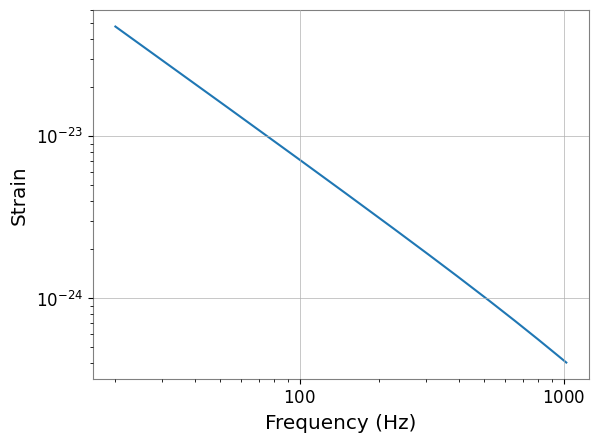

In [6]:
# Note that I have to move data to CPU to plot
# In an actual training setup, you wouldn't be moving data between devices so much
plt.plot(frequencies[freq_mask].cpu(), torch.abs(hp_f[0]).cpu())
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain")
plt.show()

### Time-domain waveforms

We'll now generate waveforms in the time domain using the `TimeDomainCBCWaveformGenerator`. This `Module` uses the `approximant` to generate a waveform `duration` seconds long with the given `sample_rate`. The coalescence point of the signal is placed `right_pad` seconds from the right edge of the window. For conditioning the frequency-domain waveforms, the parameter dictionary is required to contain the `mass_1`, `mass_2`, `s1z`, and `s2z` keys. We'll use a conversion function from [`ml4gw.waveforms.conversion`](https://github.com/ML4GW/ml4gw/blob/main/ml4gw/waveforms/conversion.py) to add these keys.

Because we're using IMRPhenomD and have aligned spins `s1z = chi1` and `s2z = chi2`. If we had non-aligned spins, we could use the `bilby_spins_to_lalsim` conversion function to compute the cartesian spin components.

In [7]:
from ml4gw.waveforms.generator import TimeDomainCBCWaveformGenerator
from ml4gw.waveforms.conversion import chirp_mass_and_mass_ratio_to_components

# The generated waveform goes through high-pass filter, removing low frequency content (TimeDomainCBCWaveformGenerator)
waveform_generator = TimeDomainCBCWaveformGenerator(
    approximant=approximant,
    sample_rate=sample_rate,
    f_min=f_min,
    duration=waveform_duration,
    right_pad=0.5,
    f_ref=f_ref,
).to(device)

params["mass_1"], params["mass_2"] = chirp_mass_and_mass_ratio_to_components(
    params["chirp_mass"], params["mass_ratio"]
)

params["s1z"], params["s2z"] = params["chi1"], params["chi2"]

hc, hp = waveform_generator(**params)
print(hc.shape, hp.shape)

torch.Size([1, 122880]) torch.Size([1, 122880])


In [8]:
params["mass_1"], params["mass_2"]

(tensor([1.3508]), tensor([1.3372]))

We now have 500 BBH waveforms, 8 seconds long and sampled at 2048 Hz. We can plot one of these as well:

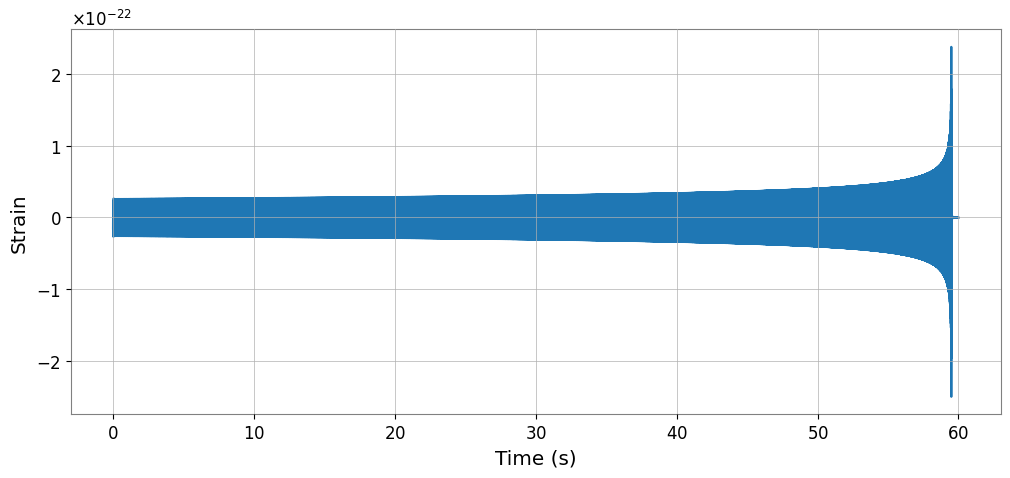

In [9]:
plt.figure(figsize=(12,5))
times = torch.arange(0, waveform_duration, 1 / sample_rate)
plt.plot(times, hp[0].cpu())
plt.xlabel("Time (s)")
plt.ylabel("Strain")
# plt.xlim(59,59.5)
plt.show()

### Waveform projection

We can now project these waveforms and get the observed strain. At present, the projection is the most basic, assuming a fixed orientation between the detector and the source over the duration of the signal. The source code for these functions can be found [here](https://github.com/ML4GW/ml4gw/blob/main/ml4gw/gw.py).

Future feature:
- Account for the Earth's rotation and orbit

In [10]:
from ml4gw.gw import get_ifo_geometry, compute_observed_strain

# Define probability distributions for sky location and polarization angle
dec = Cosine()
psi = Uniform(0, torch.pi)
phi = Uniform(-torch.pi, torch.pi)

# The interferometer geometry for V1 and K1 are also in ml4gw
ifos = ["H1", "L1"]
tensors, vertices = get_ifo_geometry(*ifos)

# Pass the detector geometry, along with the polarizations and sky parameters,
# to get the observed strain
waveforms = compute_observed_strain(
    dec=dec.sample((num_waveforms,)).to(device),
    psi=psi.sample((num_waveforms,)).to(device),
    phi=phi.sample((num_waveforms,)).to(device),
    detector_tensors=tensors.to(device),
    detector_vertices=vertices.to(device),
    sample_rate=sample_rate,
    cross=hc,
    plus=hp,
)
print(waveforms.shape)

torch.Size([1, 2, 122880])


We now have a batch of multi-channel time-series data. The first dimension is the batch dimension, and corresponds to the number of waveforms that were generated. The second dimension is the channel dimension, and corresponds to the interferometers that we chose to use in the order they were specified. The third dimension is the time dimension. 

We can plot this as well, though there won't be much difference from before.

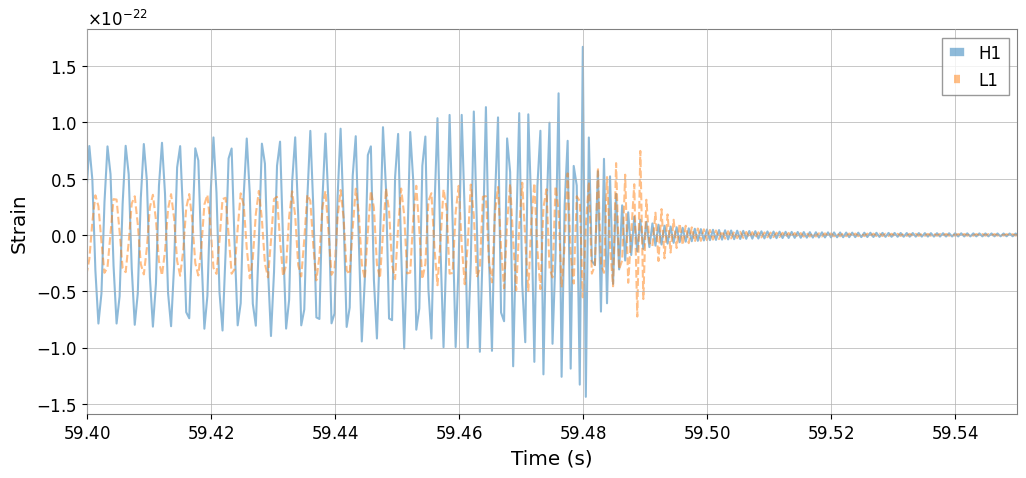

In [11]:
plt.figure(figsize=(12,5))
plt.plot(times, waveforms[0, 0].cpu(), label="H1", alpha=0.5)
plt.plot(times, waveforms[0, 1].cpu(), linestyle = '--', label="L1", alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.xlim(59.4,59.55)
plt.show()

### PSD Estimation

Now that we have our waveforms generated, one thing we might want to do is calculate their SNRs with respect to some background data. To do that, we'll need the power spectral density of the background. The [`SpectralDensity`](https://github.com/ML4GW/ml4gw/blob/main/ml4gw/transforms/spectral.py) module can take a batch of multi-channel timeseries data and compute the PSD along the time dimension. We'll begin by downloading some background data from the Gravitational Wave Open Science Center (GWOSC). This data comes from the Hanford and Livingston and was taken during O3.

One important piece to note is that, due to the scale of the strain, the background data is cast to `double` precision before being given to the module to avoid certain values being zeroed out.

Future feature:
- Automatically cast input data to `double` unless the user specifies otherwise

In [12]:
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from pathlib import Path

data_dir = Path("./data")

# And this to the directory where you want to download the data
background_dir = data_dir / "background_data_1"

In [13]:
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from pathlib import Path

# Point this to whatever directory you want to house
# all of the data products this notebook creates
data_dir = Path("./data")

# And this to the directory where you want to download the data
background_dir = data_dir / "background_data_1"
background_dir.mkdir(parents=True, exist_ok=True)

# These are the GPS time of the start and end of the segments.
# There's no particular reason for these times, other than that they
# contain analysis-ready data
segments = [
    # (1240579783, 1240587612), 
    # (1240594562, 1240606748), 
    (1240624412, 1240644412),
    (1240644412, 1240654372),
    # (1240658942, 1240668052),
]

for (start, end) in segments:
    # Download the data from GWOSC. This will take a few minutes.
    duration = end - start
    fname = background_dir / f"background-{start}-{duration}.hdf5"
    if fname.exists():
        continue

    ts_dict = TimeSeriesDict()
    for ifo in ifos:
        ts_dict[ifo] = TimeSeries.fetch_open_data(ifo, start, end, cache=True)
    ts_dict = ts_dict.resample(sample_rate)
    ts_dict.write(fname, format="hdf5")

In [13]:
from ml4gw.transforms import SpectralDensity
import h5py

fftlength = 2 # would the fft lengths change whenw e implement it for BNS signals?
spectral_density = SpectralDensity(
    sample_rate=sample_rate,
    fftlength=fftlength,
    overlap=None,
    average="median",
).to(device)

# This is H1 and L1 data from O3 that I downloaded earlier
# We have tools for dataloading that I'll get to later
background_file = background_dir / "background-1240624412-20000.hdf5"
with h5py.File(background_file, "r") as f:
    background = [torch.Tensor(f[ifo][:]) for ifo in ifos]
    background = torch.stack(background).to(device)

# Note cast to double
psd = spectral_density(background.double())
print(psd.shape)

torch.Size([2, 2049])


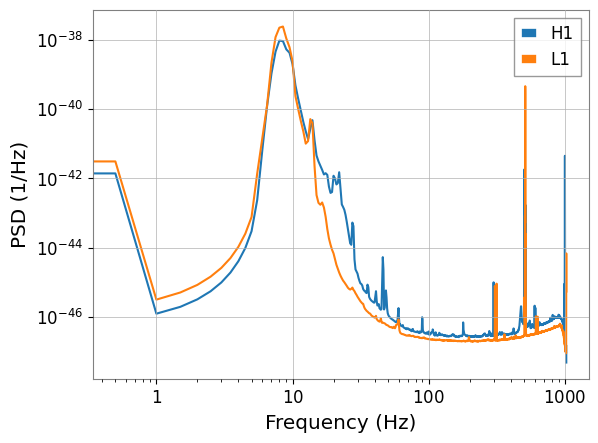

In [14]:
freqs = torch.linspace(0, nyquist, psd.shape[-1])
plt.plot(freqs, psd.cpu()[0], label="H1")
plt.plot(freqs, psd.cpu()[1], label="L1")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (1/Hz)")
plt.legend()
plt.show()

In [15]:
from ml4gw.gw import compute_ifo_snr, compute_network_snr

# Note need to interpolate
if psd.shape[-1] != num_freqs:
    # Adding dummy dimensions for consistency
    while psd.ndim < 3:
        psd = psd[None]
    psd = torch.nn.functional.interpolate(
        psd, size=(num_freqs,), mode="linear"
    )

# We can compute both the individual and network SNRs
# The SNR calculation starts at the minimum frequency we
# specified earlier and goes to the maximum
# TODO: There's probably no reason to have multiple functions
h1_snr = compute_ifo_snr(
    responses=waveforms[:, 0],
    psd=psd[:, 0],
    sample_rate=sample_rate,
    highpass=f_min,
)
l1_snr = compute_ifo_snr(
    responses=waveforms[:, 1],
    psd=psd[:, 1],
    sample_rate=sample_rate,
    highpass=f_min,
)
network_snr = compute_network_snr(
    responses=waveforms, psd=psd, sample_rate=sample_rate, highpass=f_min
)

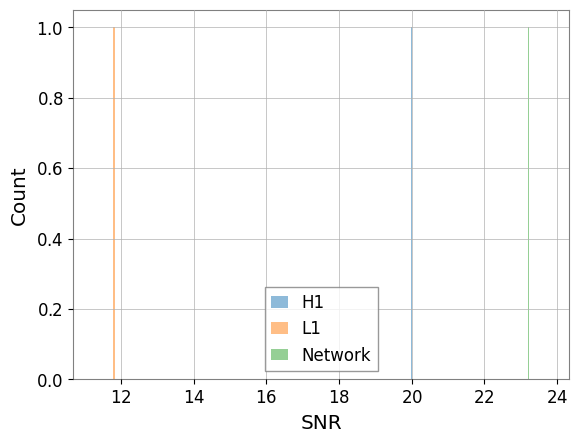

In [16]:
plt.hist(h1_snr.cpu(), bins=25, alpha=0.5, label="H1")
plt.hist(l1_snr.cpu(), bins=25, alpha=0.5, label="L1")
plt.hist(network_snr.cpu(), bins=25, alpha=0.5, label="Network")
plt.xlabel("SNR")
plt.ylabel("Count")
# plt.xlim(0, 100)
plt.legend()
plt.show()

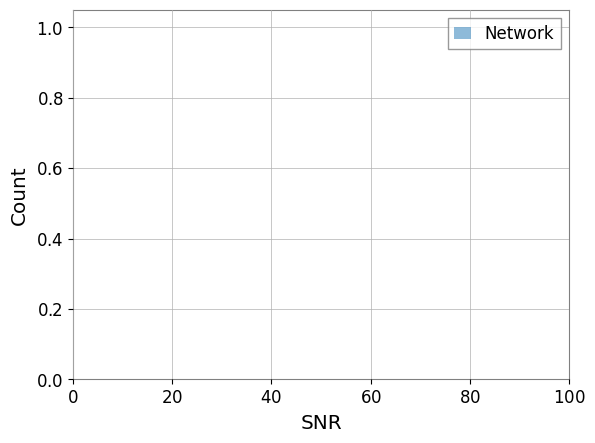

In [17]:
from ml4gw.gw import reweight_snrs

target_snrs = PowerLaw(30, 31, -3).sample((num_waveforms,)).to(device)
# target_snrs = Uniform(8, 100).sample((num_waveforms,)).to(device)
# Each waveform will be scaled by the ratio of its target SNR to its current SNR
waveforms = reweight_snrs(
    responses=waveforms,
    target_snrs=target_snrs,
    psd=psd,
    sample_rate=sample_rate,
    highpass=f_min,
)

network_snr = compute_network_snr(
    responses=waveforms, psd=psd, sample_rate=sample_rate, highpass=f_min
)

plt.hist(network_snr.cpu(), bins=25, alpha=0.5, label="Network")
plt.xlabel("SNR")
plt.ylabel("Count")
plt.xlim(0, 100)
plt.legend()
plt.show()

In [18]:
from ml4gw.dataloading import Hdf5TimeSeriesDataset

# Defining some parameters for future use, and to
# determine the size of the windows to sample.
# We're going to be whitening the last part of each
# window with a PSD calculated from the first part,
# so we need to grab enough data to do that

# Length of data used to estimate PSD
psd_length = 20 # how does the psd length changes for the BNS signal?
psd_size = int(psd_length * sample_rate)

# Length of filter. A segment of length fduration / 2
# will be cropped from either side after whitening
fduration = 0

# Length of window of data we'll feed to our network
kernel_length = 200
kernel_size = int(kernel_length * sample_rate)

# Total length of data to sample
window_length = psd_length + fduration + kernel_length

fnames = [list(background_dir.iterdir())[0]]
dataloader = Hdf5TimeSeriesDataset(
    fnames=fnames,
    channels=ifos,
    kernel_size=int(window_length * sample_rate),
    batch_size=2
    * num_waveforms,  # Grab twice as many background samples as we have waveforms
    batches_per_epoch=1,  # Just doing 1 here for demonstration purposes
    coincident=False,
)

background_samples = [x for x in dataloader][0].to(device)
print(background_samples.shape)

torch.Size([2, 2, 450560])


In [19]:
from ml4gw.transforms import Whiten

# whiten = Whiten(
#     fduration=fduration, sample_rate=sample_rate, highpass=f_min
# ).to(device)

# Create PSDs using the first psd_length seconds of each sample
# with the SpectralDensity module we defined earlier
psd = spectral_density(background_samples[..., :psd_size].double())
print(f"PSD shape: {psd.shape}")

# Take everything after the first psd_length as our input kernel
kernel = background_samples[..., psd_size:]

pad1 = int(10*sample_rate)

# And whiten using our PSDs
# whitened_kernel = whiten(kernel, psd)
# print(f"Kernel shape: {kernel.shape}")
# print(f"Whitened kernel shape: {whitened_kernel.shape}")

PSD shape: torch.Size([2, 2, 2049])


In [20]:
num_freqs1 = (kernel_length*2048) // 2 + 1

if psd.shape[-1] != num_freqs1:
    # Adding dummy dimensions for consistency
    while psd.ndim < 3:
        psd = psd[None]
    psd = torch.nn.functional.interpolate(
        psd, size=(num_freqs1,), mode="linear"
    )

In [21]:
wave = torch.nn.functional.pad(waveforms, [8*pad1, 6*pad1])
template_waveform = torch.nn.functional.pad(waveforms, [14*pad1,0])
# template_waveform = torch.nn.functional.pad(waveforms, [0, 2*pad1])
background_strain = kernel[0].unsqueeze(0) + wave
psd_waveform = psd[0].unsqueeze(0)

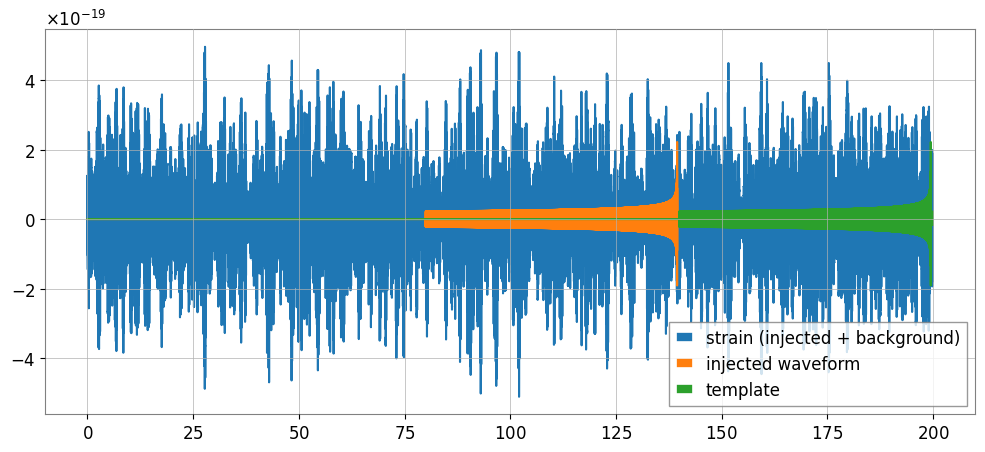

In [22]:
plt.figure(figsize=(12,5))
t1 = torch.arange(0, kernel_length, 1/2048)
t2 = torch.arange(0, 200, 1/2048)
plt.plot(t1, background_strain[0][0], label='strain (injected + background)')
plt.plot(t1, 1000*wave[0][0], label='injected waveform')
plt.plot(t1, 1000*template_waveform[0][0], label='template')
plt.legend(loc='best')

### PyCBC match_filter tutorials

In [28]:
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from gwosc.datasets import event_gps

In [29]:
gps = event_gps('GW170817')
print("GW170817 GPS:", gps)

ldata = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
print("GW170817 data")
print(ldata)

GW170817 GPS: 1187008882.4
GW170817 data
TimeSeries([2.06056010e-20, 1.59181918e-20, 2.18438811e-20, ...,
            1.25504332e-19, 1.23976846e-19, 1.22231459e-19]
           unit: dimensionless,
           t0: 1187008370.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


In [30]:
# %matplotlib inline
import numpy
import pylab

# specify the sample rate.
# LIGO raw data is sampled at 16384 Hz (=2^14 samples/second).
# It captures signal frequency content up to f_Nyquist = 8192 Hz.
# Here, we will make the computation faster by sampling at a lower rate.
sample_rate = 1024 # samples per second
data_length = 1024 # seconds

# Generate a long stretch of white noise: the data series and the time series.
data = numpy.random.normal(size=[sample_rate * data_length])
times = numpy.arange(len(data)) / float(sample_rate)

In [31]:
from pycbc.waveform import get_td_waveform

# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD (a phenomenological Inspiral–Merger–Ringdown wafeform model) is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.
apx = 'IMRPhenomD'

In [32]:
hp1, _ = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

In [33]:
hp1 = hp1 / max(numpy.correlate(hp1, hp1, mode='full'))**0.5

Text(0, 0.5, 'Normalized amplitude')

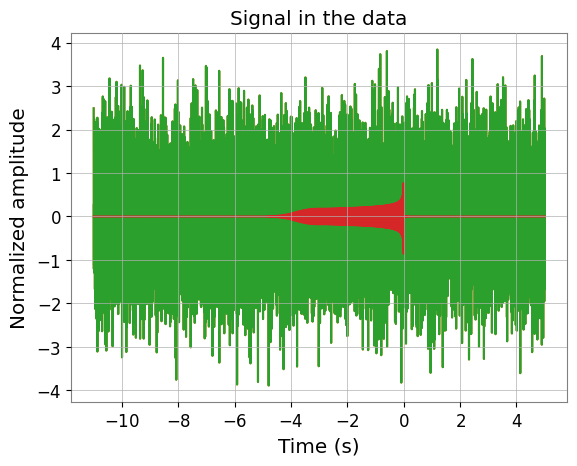

In [34]:
plt.figure()
plt.title("The waveform hp1")
plt.plot(hp1.sample_times, hp1)
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')

# Shift the waveform to start at a random time in the Gaussian noise data.
waveform_start = numpy.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

plt.title("Looks like random noise, right?")
plt.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')

plt.title("Signal in the data")
plt.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
plt.plot(hp1.sample_times, 10 * hp1)
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')

# plt.show()

Text(0, 0.5, 'Cross-correlation')

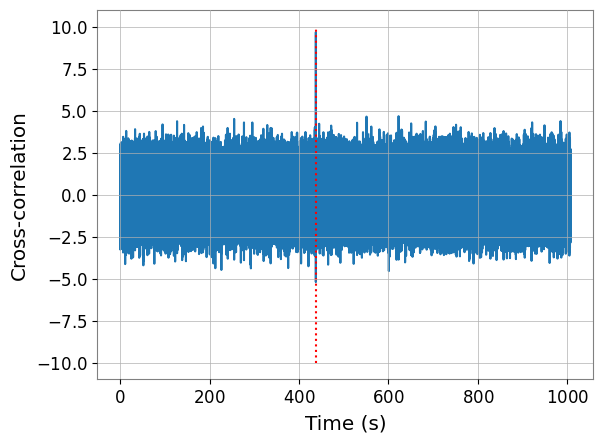

In [35]:
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1_numpy = hp1.numpy()
for i in range(len(data) - len(hp1_numpy)):
    cross_correlation[i] = (hp1_numpy * data[i:i+len(hp1_numpy)]).sum()

# plot the cross-correlated data vs time. Superimpose the location of the end of the signal;
# this is where we should find a peak in the cross-correlation.
plt.figure()
times = numpy.arange(len(data) - len(hp1_numpy)) / float(sample_rate)
plt.plot(times, cross_correlation)
plt.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)], [-10,10],'r:')
plt.xlabel('Time (s)')
plt.ylabel('Cross-correlation')

# plt.show()

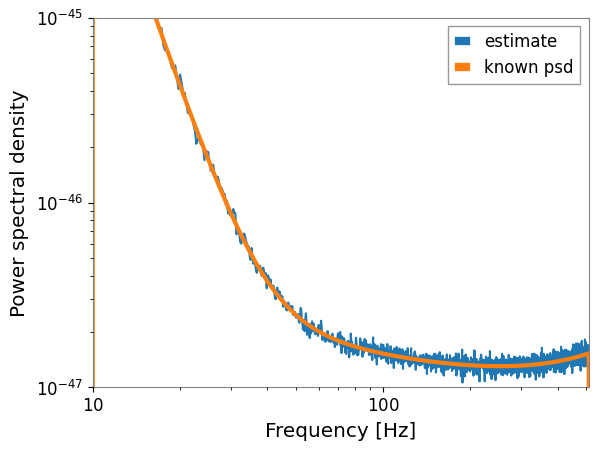

In [36]:
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide:
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve 
flow = 10.0
delta_f = 1.0 / 128
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate colored noise
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)

# Estimate the amplitude spectral density (ASD = sqrt(PSD)) for the noisy data 
# using the "welch" method. We'll choose 4 seconds PSD samples that are overlapped 50%
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts,seg_len=seg_len,seg_stride=seg_stride)

# plot it:
pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
pylab.xlim(xmin=flow, xmax=512)
pylab.ylim(1e-47, 1e-45)
pylab.xlabel('Frequency [Hz]')
pylab.ylabel('Power spectral density')
pylab.legend()
pylab.grid()
pylab.show()

# add the signal, this time, with a "typical" amplitude.
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20

plt.show()

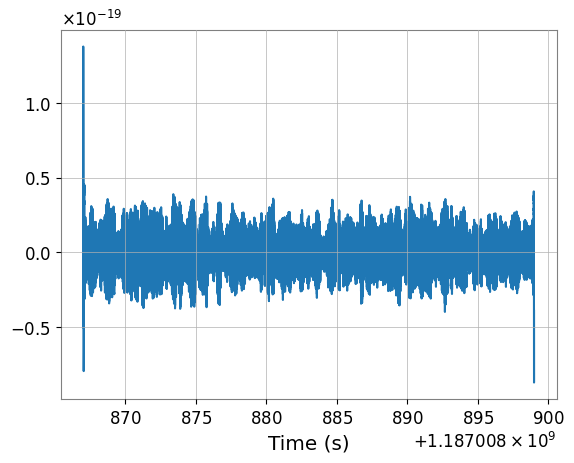

In [37]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

# As an example we use the GW150914 data
merger = Merger("GW170817")

# Get the data from the Hanford detector
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()


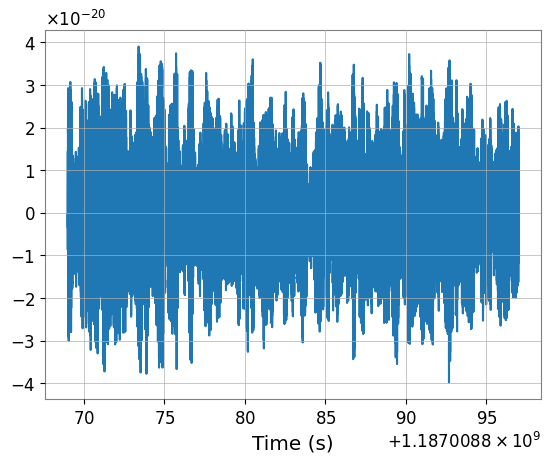

In [38]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [39]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [40]:
from pycbc.waveform import get_td_waveform

m = 1.4 # Solar masses
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))

Text(0, 0.5, 'Strain')

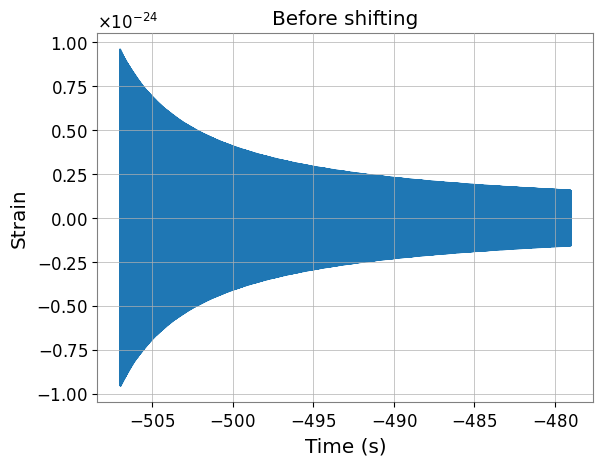

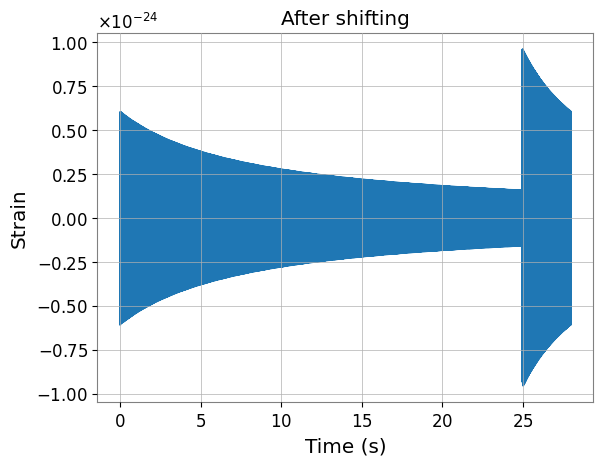

In [41]:
# Let's plot the signal before and after shifting

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

# pylab.show()

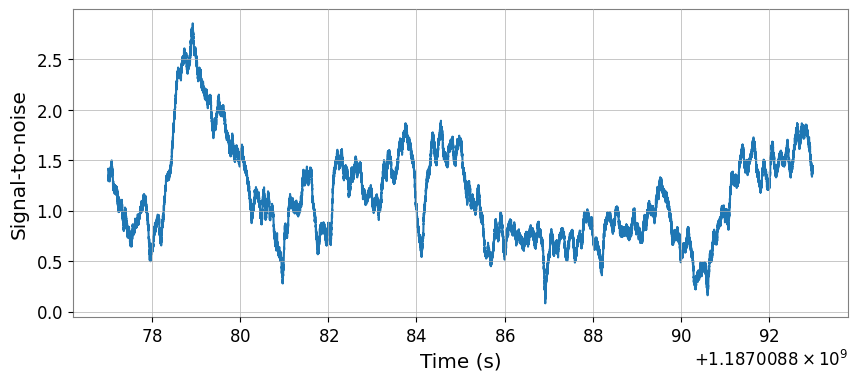

We found a signal at 1187008878.9194336s with SNR 2.858669014606593


In [42]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [43]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

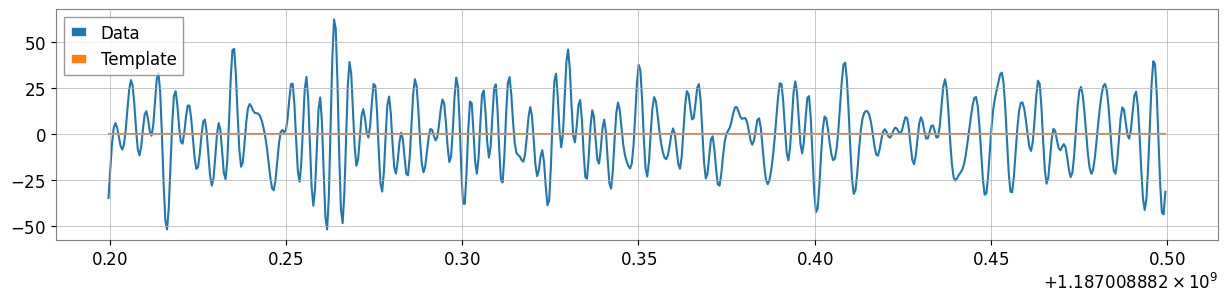

In [44]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

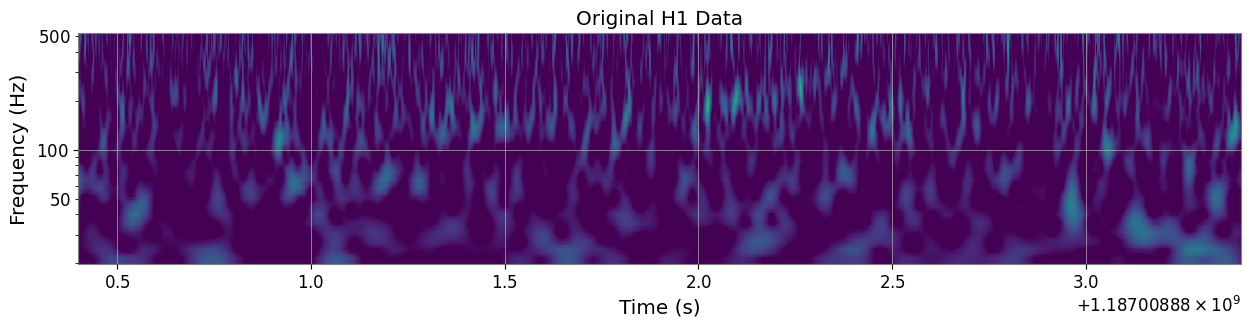

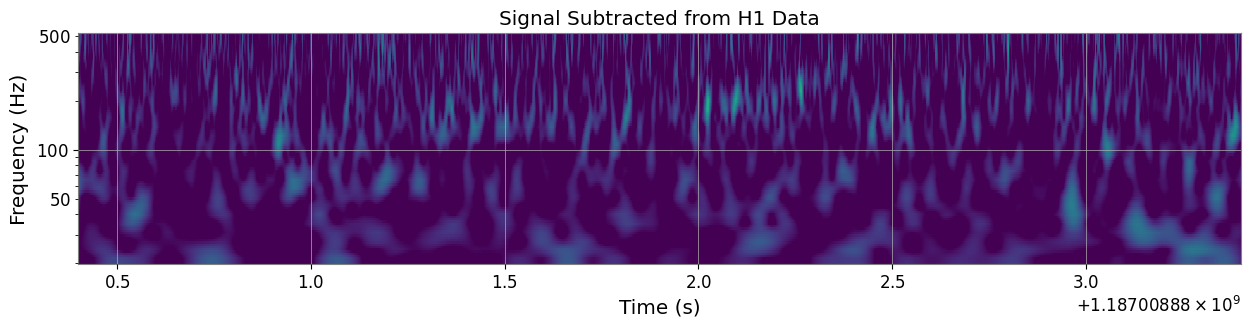

In [45]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

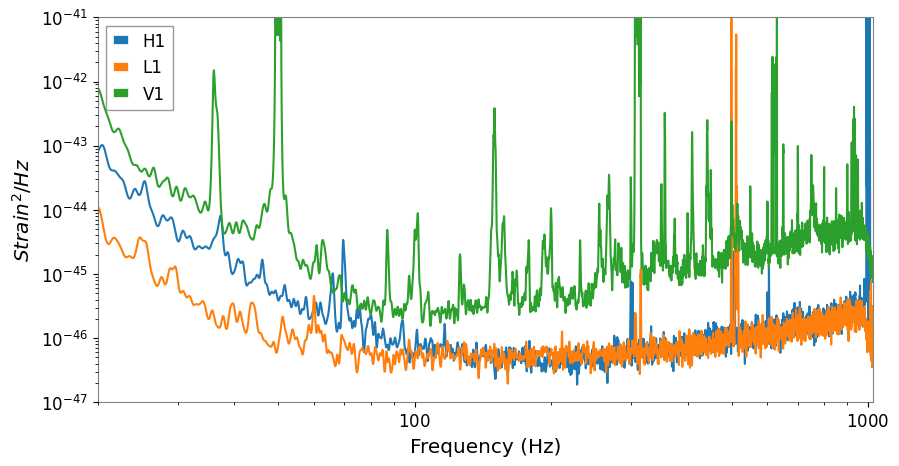

In [46]:
import pylab

from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

m = Merger("GW170814")

ifos = ['H1', 'L1', 'V1']
data = {}
psd = {}

pylab.figure(figsize=[10, 5])

for ifo in ifos:
    # Read in and precondition the data
    ts = m.strain(ifo).highpass_fir(15, 512)
    data[ifo] = resample_to_delta_t(ts, 1.0/2048).crop(2, 2)

    # Estimate the power spectral density of the data
    # This chooses to use 2s samples in the PSD estimate.
    # One should note that the tradeoff in segment length is that
    # resolving narrow lines becomes more difficult.
    p = data[ifo].psd(2)
    p = interpolate(p, data[ifo].delta_f)
    p = inverse_spectrum_truncation(p, int(2 * data[ifo].sample_rate), low_frequency_cutoff=15.0)
    psd[ifo] = p
    
    pylab.plot(psd[ifo].sample_frequencies, psd[ifo], label=ifo)

pylab.yscale('log')
pylab.xscale('log')
pylab.ylim(1e-47, 1e-41)
pylab.xlim(20, 1024)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.legend()
pylab.show()

In [47]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter

# Calculate the component mass of each black hole in the detector frame
cmass = (m.median1d("mass1")+m.median1d("mass2")) / 2      # This is in the source frame
cmass *= (1 + m.median1d("redshift")) # apply redshift to get to the detector frame

# This is a frequency domain waveform generator. It has a very similar syntax to the time domain
# waveform function used in prior tutorials. This function returns both a plus and a cross
# polarization waveform, but we will just use the plus polarization in building our template
# as these are only different by a phase offset in this specific case.
hp, _ = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=cmass, mass2=cmass,
                         f_lower=20.0, delta_f=data[ifo].delta_f)
hp.resize(len(psd[ifo]))

# For each observatory use this template to calculate the SNR time series
snr = {}
for ifo in ifos:
    snr[ifo] = matched_filter(hp, data[ifo], psd=psd[ifo], low_frequency_cutoff=20)
    snr[ifo] = snr[ifo].crop(5, 4)

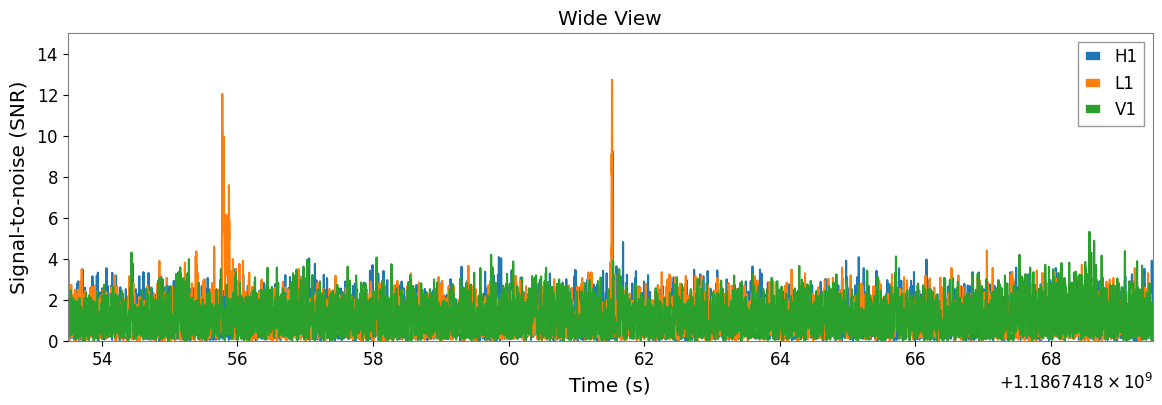

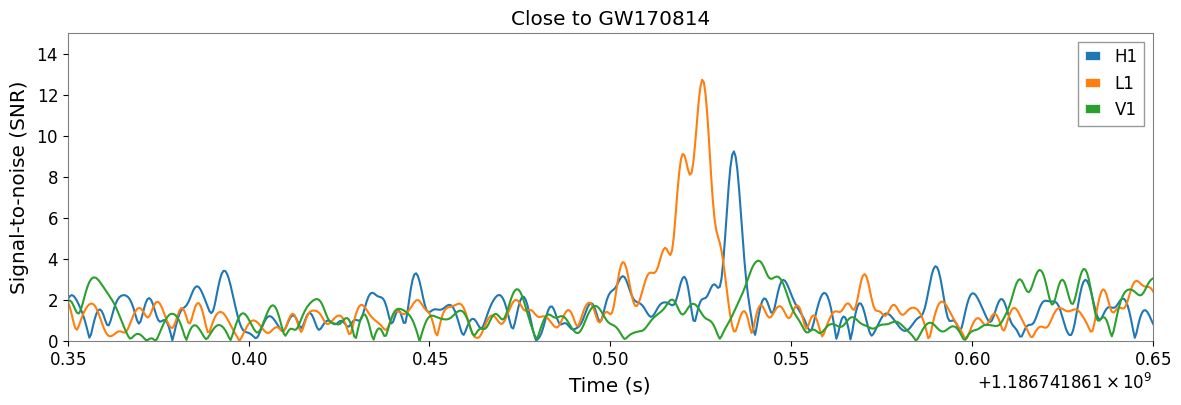

In [48]:
# Show a couple sizes
for w, title in [(8, 'Wide View'), (.15, 'Close to GW170814')]:
    pylab.figure(figsize=[14, 4])
    for ifo in ifos:
        pylab.plot(snr[ifo].sample_times, abs(snr[ifo]), label=ifo)

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(m.time - w, m.time + w)
    pylab.ylim(0, 15)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Signal-to-noise (SNR)')
    pylab.show()

In [49]:
from pycbc.vetoes import power_chisq

chisq = {}
for ifo in ifos:
    # The number of bins to use. In principle, this choice is arbitrary. In practice,
    # this is empirically tuned.
    nbins = 26
    chisq[ifo] = power_chisq(hp, data[ifo], nbins, psd[ifo], low_frequency_cutoff=20.0)
    chisq[ifo] = chisq[ifo].crop(5, 4)
    
    dof = nbins * 2 - 2
    chisq[ifo] /= dof

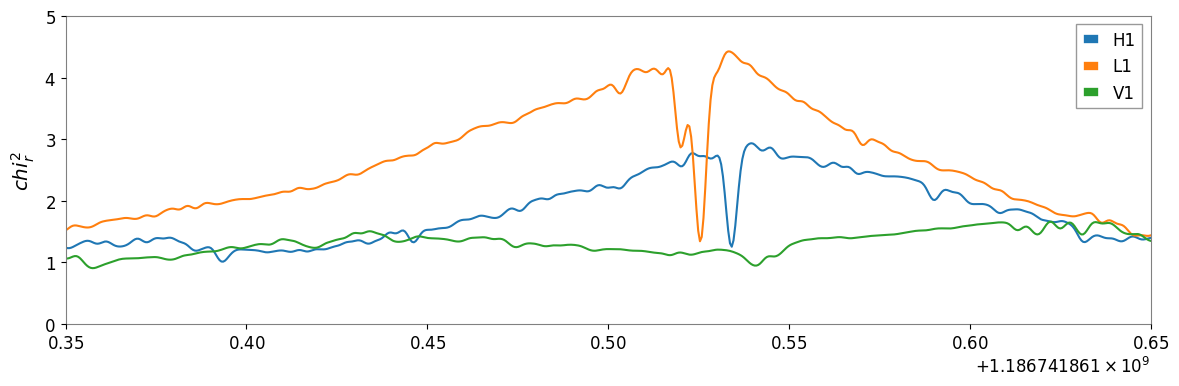

In [50]:
pylab.figure(figsize=[14, 4])

for ifo in ifos:
    pylab.plot(chisq[ifo].sample_times, chisq[ifo], label=ifo)
    
pylab.legend()
pylab.grid()
pylab.xlim(m.time -0.15, m.time + 0.15)
pylab.ylim(0, 5)
pylab.ylabel('$chi^2_r$')
pylab.show()

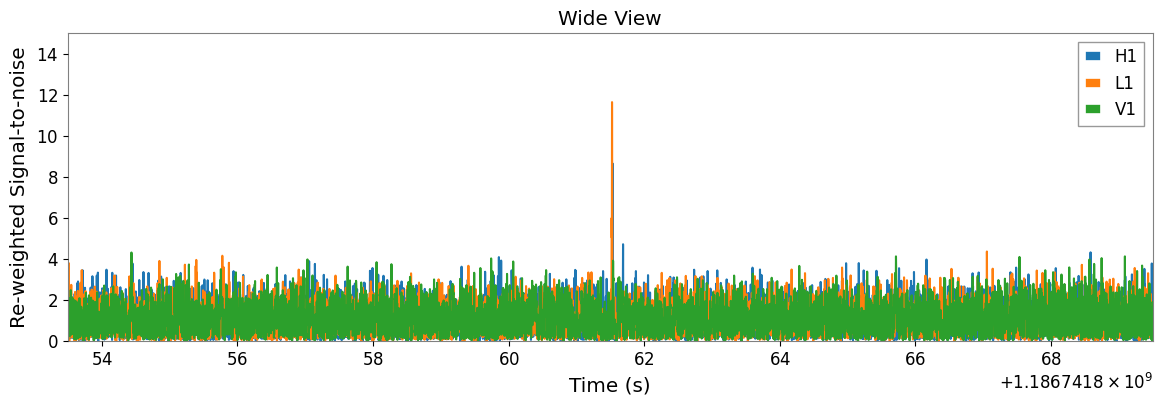

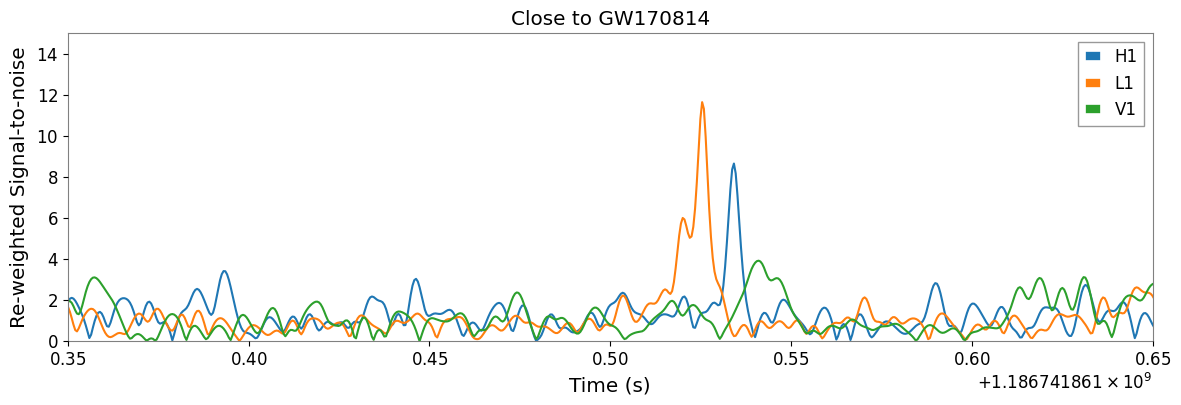

In [51]:
from pycbc.events.ranking import newsnr

# The rho-hat term above is named "newsnr" here
nsnr = {ifo:newsnr(abs(snr[ifo]), chisq[ifo]) for ifo in ifos}

# Show a couple sizes
for w, title in [(8, 'Wide View'), (.15, 'Close to GW170814')]:
    pylab.figure(figsize=[14, 4])
    for ifo in ifos:
        pylab.plot(snr[ifo].sample_times, nsnr[ifo], label=ifo)

    pylab.legend()
    pylab.title(title)
    pylab.grid()
    pylab.xlim(m.time - w, m.time + w)
    pylab.ylim(0, 15)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Re-weighted Signal-to-noise')
    pylab.show()

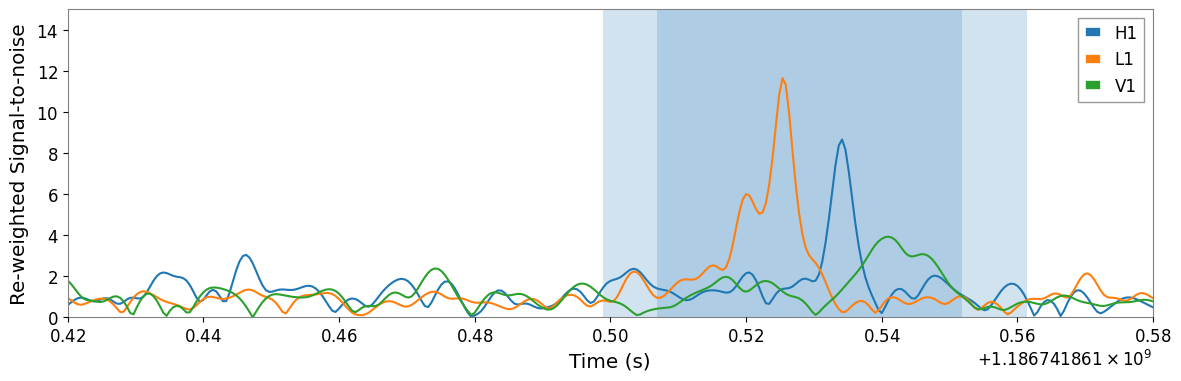

Virgo Peak has a statistic value of 3.92806733210622


In [52]:
import numpy
from pycbc.detector import Detector

# Calculate the time of flight between the Virgo detectors and each LIGO observatory
d = Detector("V1")
tof = {}
tof['H1'] = d.light_travel_time_to_detector(Detector("H1"))
tof['L1'] = d.light_travel_time_to_detector(Detector("L1"))

# Record the time of the peak in the LIGO observatories
ptime = {}

pylab.figure(figsize=[14, 4])
for ifo in ifos:
    
    # shade the region around each LIGO peak that could have a peak in Virgo if from
    # an astrophysical source
    if ifo != 'V1':
        ptime[ifo] = snr[ifo].sample_times[nsnr[ifo].argmax()]
        pylab.axvspan(ptime[ifo] - tof[ifo], ptime[ifo] + tof[ifo], alpha=0.2, lw=10)
        
    pylab.plot(snr[ifo].sample_times, nsnr[ifo], label=ifo)

# Calculate the span of time that a Virgo peak could in principle happen in from time of flight
# considerations.
start = ptime['H1'] - tof['H1']
end = ptime['L1'] + tof['L1']

# convert the times to indices along with how large the region is in number of samples
window_size = int((end - start) * snr['V1'].sample_rate)
sidx = int((start - snr['V1'].start_time) * snr['V1'].sample_rate)
eidx = sidx + window_size

# Calculate the "on-source" peak re-weighted (newsnr) statistic value.
onsource = nsnr['V1'][sidx:eidx].max()

pylab.legend()
pylab.grid()
pylab.xlim(m.time - .08, m.time + .08)
pylab.ylim(0, 15)
pylab.xlabel('Time (s)')
pylab.ylabel('Re-weighted Signal-to-noise')
pylab.show()

print('Virgo Peak has a statistic value of {}'.format(onsource))

In [53]:
# Now that we've calculated the onsource peak, we should calculate the background peak values.
# We do this by chopping up the time series into chunks that are the same size as our
# onsource and repeating the same peak finding (max) procedure.

# Walk through the data in chunks and calculate the peak statistic value in each.
peaks = []
i = 0
while i + window_size < len(nsnr['V1']):
    p = nsnr['V1'][i:i+window_size].max()
    peaks.append(p)
    i += window_size
    
    # Skip past the onsource time
    if abs(i - sidx) < window_size:
        i += window_size * 2
    
peaks = numpy.array(peaks)


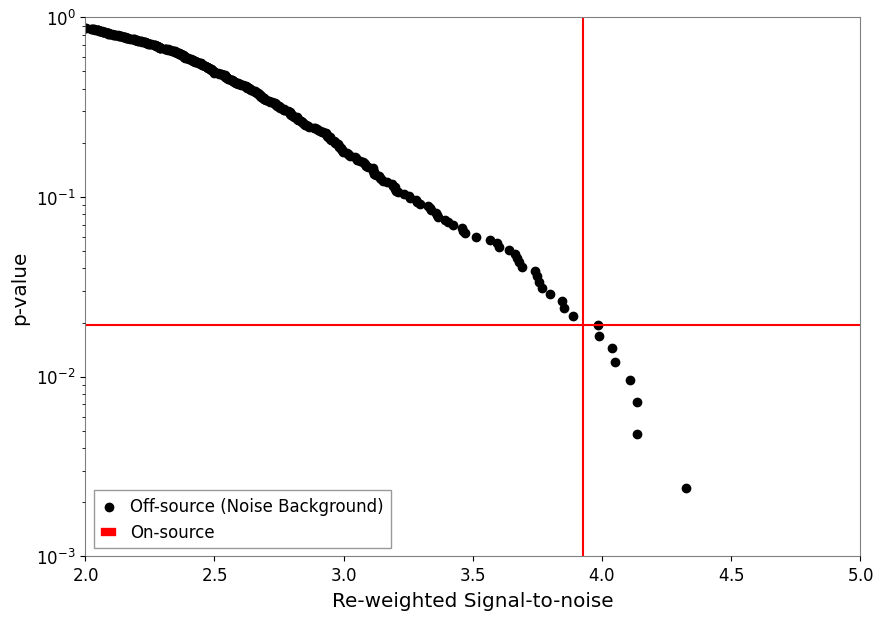

The p-value associated with the GW170814 peak is 0.01927710843373494


In [54]:
# The p-value is just the number of samples observed in the background with a 
# value equal or higher than the onsource divided by the number of samples.
# We can make the mapping between statistic value and p-value using our background
# samples.
pcurve = numpy.arange(1, len(peaks)+1)[::-1] / float(len(peaks))
peaks.sort()

pvalue = (peaks > onsource).sum() / float(len(peaks))

pylab.figure(figsize=[10, 7])
pylab.scatter(peaks, pcurve, label='Off-source (Noise Background)', color='black')

pylab.axvline(onsource, label='On-source', color='red')
pylab.axhline(pvalue, color='red')

pylab.legend()
pylab.yscale('log')
pylab.grid()
pylab.ylim(1e-3, 1e0)
pylab.ylabel('p-value')
pylab.xlabel('Re-weighted Signal-to-noise')

pylab.xlim(2, 5)
pylab.show()

print("The p-value associated with the GW170814 peak is {}".format(pvalue))

### Running matched_filter on my dataset

In [116]:
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.filter import matched_filter
from pycbc.psd import aLIGOZeroDetHighPower
import numpy as np

# template_h1 = TimeSeries(template_waveform[0][0].numpy(), delta_t=1/2048)
template_h1 = TimeSeries(template_waveform[0][0].numpy(), delta_t=1/2048)
data_h1 = TimeSeries(background_strain[0][0].numpy(), delta_t=1/2048)
# data_h1 = TimeSeries(kernel[0].unsqueeze(0)[0][0].double().numpy(), delta_t=1/2048)
psd_h1 = FrequencySeries(psd_waveform[0][0].numpy(), delta_f=1/200)
# data_h1 = TimeSeries(wave[0][0].numpy(), delta_t=1/2048)
# psd_h1 = aLIGOZeroDetHighPower(len(data_h1), delta_f=1/200, low_freq_cutoff = 20)
# N = len(data_h1) 
# psd_array = np.ones(N//2 + 1)  

# psd_h1 = FrequencySeries(psd_array, delta_f=1/200)

snr_h1 = matched_filter(template_h1, data_h1, psd=psd_h1, low_frequency_cutoff=20)

In [117]:
# template_l1 = TimeSeries(template_waveform[0][1].numpy(), delta_t=1/2048)
template_l1 = TimeSeries(template_waveform[0][1].numpy(), delta_t=1/2048)
data_l1 = TimeSeries(background_strain[0][1].numpy(), delta_t=1/2048)
# data_l1 = TimeSeries(kernel[0].unsqueeze(0)[0][1].double().numpy(), delta_t=1/2048)
psd_l1 = FrequencySeries(psd_waveform[0][1].numpy(), delta_f=1/200)
# data_l1 = TimeSeries(wave[0][1].numpy(), delta_t=1/2048) 
# psd_l1 = aLIGOZeroDetHighPower(len(data_l1), delta_f=1/200, low_freq_cutoff = 20)
# N = len(data_l1) 
# psd_array = np.ones(N//2 + 1)  

# psd_l1 = FrequencySeries(psd_array, delta_f=1/200)

snr_l1 = matched_filter(template_l1, data_l1, psd=psd_l1, low_frequency_cutoff=20)

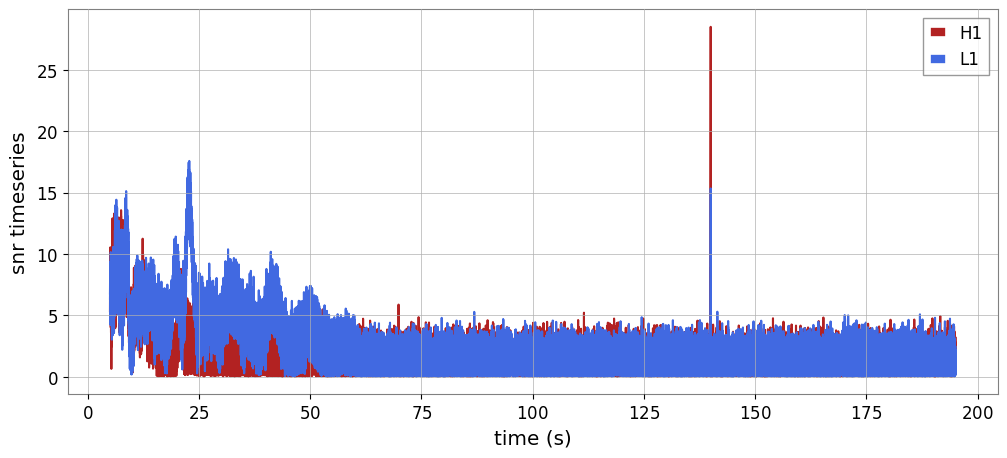

In [118]:
plt.figure(figsize=(12,5))

plt.plot((snr_h1.crop(5, 5)).sample_times, abs(snr_h1.crop(5, 5)), color = 'firebrick', label='H1')
plt.plot((snr_l1.crop(5, 5)).sample_times, abs(snr_l1.crop(5, 5)), color = 'royalblue', label='L1')
# plt.axvline(160, linestyle='--', color = 'grey')

plt.xlabel('time (s)')
plt.ylabel('snr timeseries')
plt.legend(loc='best')

# plt.xlim(119, 121)
# plt.ylim(0,30)

In [119]:
print('Detected SNR =',np.sqrt((abs(snr_h1).max())**2 + (abs(snr_l1).max())**2))

Detected SNR = 51.406673599820174


In [120]:
from pycbc.vetoes import power_chisq

nbins = 26
dof = nbins * 2 - 2

chisq_h1 = power_chisq(template_h1, data_h1, nbins, psd_h1, low_frequency_cutoff=20.0)
chisq_h1 /= dof

chisq_l1 = power_chisq(template_l1, data_l1, nbins, psd_l1, low_frequency_cutoff=20.0)
chisq_l1 /= dof

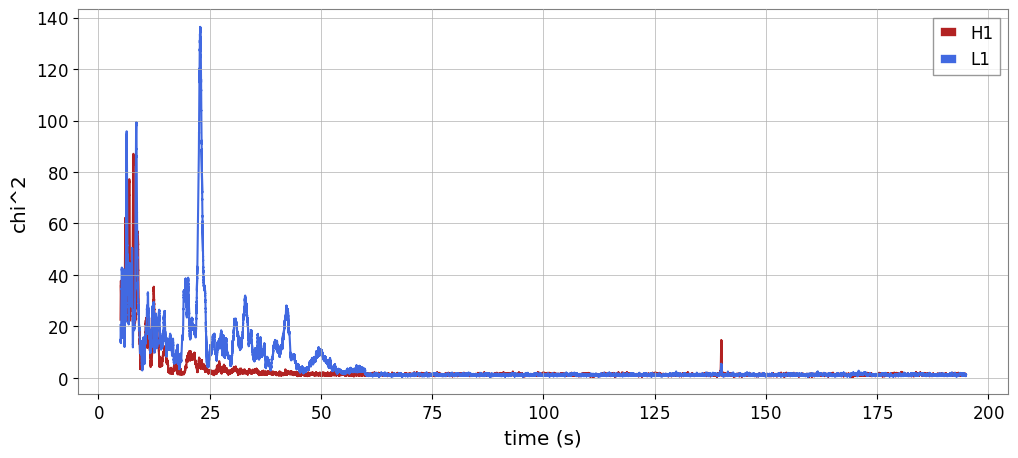

In [121]:
plt.figure(figsize=(12,5))

plt.plot((chisq_h1.crop(5, 5)).sample_times, abs(chisq_h1.crop(5, 5)), color = 'firebrick', label='H1')
plt.plot((chisq_l1.crop(5, 5)).sample_times, abs(chisq_l1.crop(5, 5)), color = 'royalblue', label='L1')

plt.xlabel('time (s)')
plt.ylabel('chi^2')
plt.legend(loc='best')

# plt.xlim(139, 141)
# plt.ylim(0,30)

In [122]:
from pycbc.events.ranking import newsnr

nsnr_h1 = newsnr(abs(snr_h1), chisq_h1)
nsnr_l1 = newsnr(abs(snr_l1), chisq_l1)

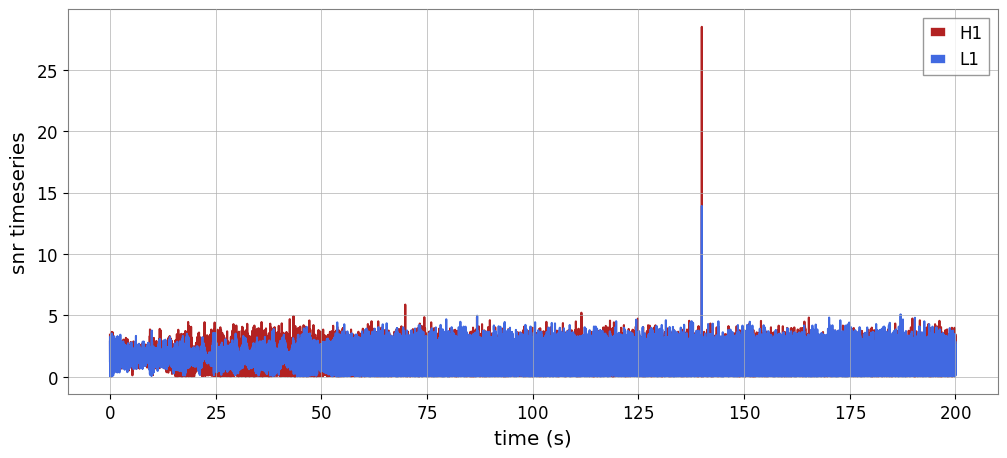

In [123]:
plt.figure(figsize=(12,5))

plt.plot(snr_h1.sample_times, abs(nsnr_h1), color = 'firebrick', label='H1')
plt.plot(snr_l1.sample_times, abs(nsnr_l1), color = 'royalblue', label='L1')
# plt.axvline(160, linestyle='--', color = 'grey')

plt.xlabel('time (s)')
plt.ylabel('snr timeseries')
plt.legend(loc='best')

# plt.xlim(119, 121)
# plt.ylim(0,30)

In [124]:
print('Detected SNR =',np.sqrt((nsnr_h1.max())**2 + (nsnr_l1.max())**2))

Detected SNR = 31.723823765525953
